In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
df = pd.read_csv('data.csv', index_col=0)
df.head()

,target,ids,date,flag,user,text
0,0,2231089412,Thu Jun 18 18:01:49 PDT 2009,NO_QUERY,claudiatweets,two more days in mexico
1,4,1677444253,Sat May 02 02:06:26 PDT 2009,NO_QUERY,Lirolad,Good morning
2,4,2062350163,Sat Jun 06 22:59:26 PDT 2009,NO_QUERY,sexyseshy,listing to movies by sleepdistrict
3,0,1989822107,Mon Jun 01 02:56:05 PDT 2009,NO_QUERY,MoffatSM,I dont like working when its sunny
4,4,2053589307,Sat Jun 06 05:04:26 PDT 2009,NO_QUERY,ashalynd,"@somesheep thanks, a nice one and I didn't kno..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275740 entries, 0 to 275739
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  275740 non-null  int64 
 1   ids     275740 non-null  int64 
 2   date    275740 non-null  object
 3   flag    275740 non-null  object
 4   user    275740 non-null  object
 5   text    275740 non-null  object
dtypes: int64(2), object(4)
memory usage: 14.7+ MB


In [7]:
df.describe()

,target,ids
count,275740.000000,2.757400e+05
mean,1.996286,1.998806e+09
std,2.000000,1.934701e+08
min,0.000000,1.467810e+09
25%,0.000000,1.957004e+09
50%,0.000000,2.002132e+09
75%,4.000000,2.176998e+09
max,4.000000,2.329205e+09


<Axes: xlabel='target'>

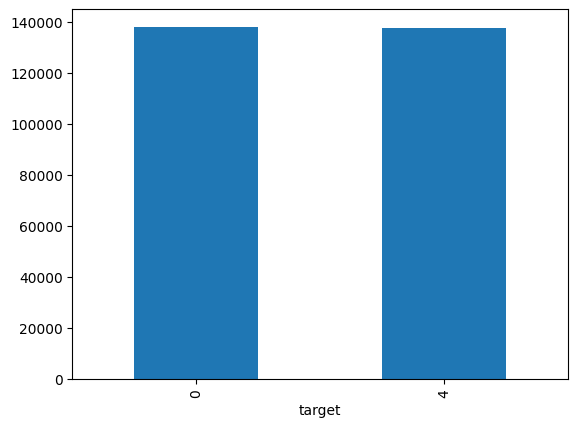

In [8]:
df['target'].value_counts().plot(kind='bar')

In [9]:
df.duplicated().sum()

0

In [10]:
df = df[["target","text"]]
df.head()

,target,text
0,0,two more days in mexico
1,4,Good morning
2,4,listing to movies by sleepdistrict
3,0,I dont like working when its sunny
4,4,"@somesheep thanks, a nice one and I didn't kno..."


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.duplicated().sum()


0

In [13]:
X = df[['text']]
y = df['target']

array([[<Axes: title={'center': 'text'}>]], dtype=object)

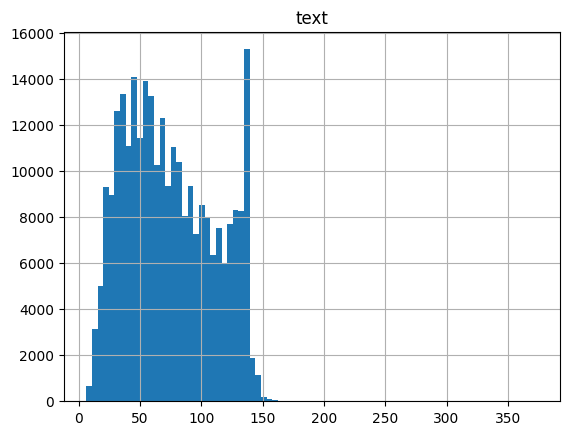

In [14]:
X.map(len).hist(bins = 80)

In [15]:
X.map(lambda x: len(x.split()) == 0).sum()

,0
text,0


In [16]:
def remove_patterns(text):

    text = re.sub(r'http[s]?://\S+', '', text)

    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    text = re.sub(r'@\w+', '', text)

    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

X['text'] = X['text'].map(remove_patterns)
X['text'].head()

<ipython-input-16-7f042c085bcc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].map(remove_patterns)


,text
0,two more days in mexico
1,Good morning
2,listing to movies by sleepdistrict
3,I dont like working when its sunny
4,thanks a nice one and I didnt know about it


In [17]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [19]:
def remove_stopwords(text):
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

In [20]:
X['text'] = X['text'].map(remove_stopwords)
X['text'].head()

<ipython-input-20-1d833f2f5e5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = X['text'].map(remove_stopwords)


,text
0,two day mexico
1,good morn
2,list movi sleepdistrict
3,dont like work sunni
4,thank nice one didnt know


In [21]:
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X['text'])

In [22]:
y = y == 0
y = y.astype(int)
y.value_counts()

,count
target,
1,137288
0,137123


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [24]:
bayes = MultinomialNB()
bayes.fit(X_train, y_train)

MultinomialNB()

In [25]:
bayes.score(X_test, y_test)

0.7575205437020571

In [26]:
print(classification_report(y_test, bayes.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75     27491
           1       0.74      0.78      0.76     27392

    accuracy                           0.76     54883
   macro avg       0.76      0.76      0.76     54883
weighted avg       0.76      0.76      0.76     54883



In [27]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [28]:
X = X["text"]
X[: 5]

,text
0,two day mexico
1,good morn
2,list movi sleepdistrict
3,dont like work sunni
4,thank nice one didnt know


In [29]:
X_list = X.tolist()
sample = X_list[: 5]
sample

['two day mexico',
 'good morn',
 'list movi sleepdistrict',
 'dont like work sunni',
 'thank nice one didnt know']

In [30]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

In [31]:
vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary size: {vocab_size}")


Vocabulary size: 114052


In [32]:
X.map(len).max()

168

In [33]:
max_length = 200
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219528, 200), (54883, 200), (219528,), (54883,))

In [36]:
#tf.keras.backend.clear_session()

In [37]:
lstm_model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=10000, output_dim=128),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,289,569 (4.92 MB)

 Trainable params: 1,289,569 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [40]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/20
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.4991 - loss: 0.6933 - val_accuracy: 0.4993 - val_loss: 0.6932
Epoch 2/20
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5007 - val_loss: 0.6932
Epoch 3/20
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.4993 - val_loss: 0.6932
Epoch 4/20
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.4988 - loss: 0.6932 - val_accuracy: 0.4993 - val_loss: 0.6931
Epoch 5/20
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.5007 - val_loss: 0.6931
Epoch 6/20
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4993 - val_loss: 0.6932
Epoch 7/20
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.5007 - val_loss: 0.6931
Epoch 8/20
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.5011 -

In [43]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [44]:
print(' Original: ', X_list[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(X_list[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_list[0])))

 Original:  two day mexico
Tokenized:  ['two', 'day', 'mexico']
Token IDs:  [2048, 2154, 3290]


In [45]:
max_len = 0

# For every sentence...
for sent in X_list:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  136


In [46]:
import torch

In [48]:
y

,target
0,1
1,0
2,0
3,1
4,0
...,...
275735,0
275736,0
275737,0
275738,0


In [49]:
input_ids = []
attention_masks = []

# For every tweet...
for tweet in X_list:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',# Return pytorch tensors.
                        truncation=True
                   )


    input_ids.append(encoded_dict['input_ids'])


    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y.values)

# Print sentence 0, now as a list of IDs.
print('Original: ', X_list[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  two day mexico
Token IDs: tensor([ 101, 2048, 2154, 3290,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [51]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split